# TP 6 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [2]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *
import cv2

In [147]:
from functions import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
flags = [i for i in dir(cv2) if i.startswith("COLOR_")]

In [6]:
len(flags)

346

In [7]:
flags[40]

'COLOR_BAYER_GR2GRAY'

***
## 1.a - Nemo Segmentation

In [8]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb

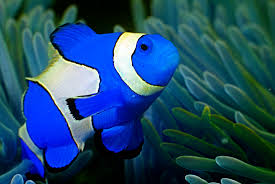

In [9]:
nemo = cv2.imread("img/nemo0.jpg")
h, w = nemo.shape[:2]
displayImage_fromcv2(nemo, w, h)

OpenCV lee por defecto las imagenes en BGR, por lo cual es necesario una conversión a RGB para poder visualizarla correctamente.

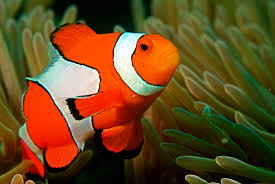

In [10]:
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
h, w = nemo.shape[:2]
displayImage_fromcv2(nemo, w, h)

Si proyectamos los valores de color RGB como coordenadas en el espacio, donde por ejemplo, un pixel rojo tendrá coordenadas (255, 0, 0), y uno negro tendrá (0, 0, 0). Obtendremos una distribución de pixeles en el espacio.

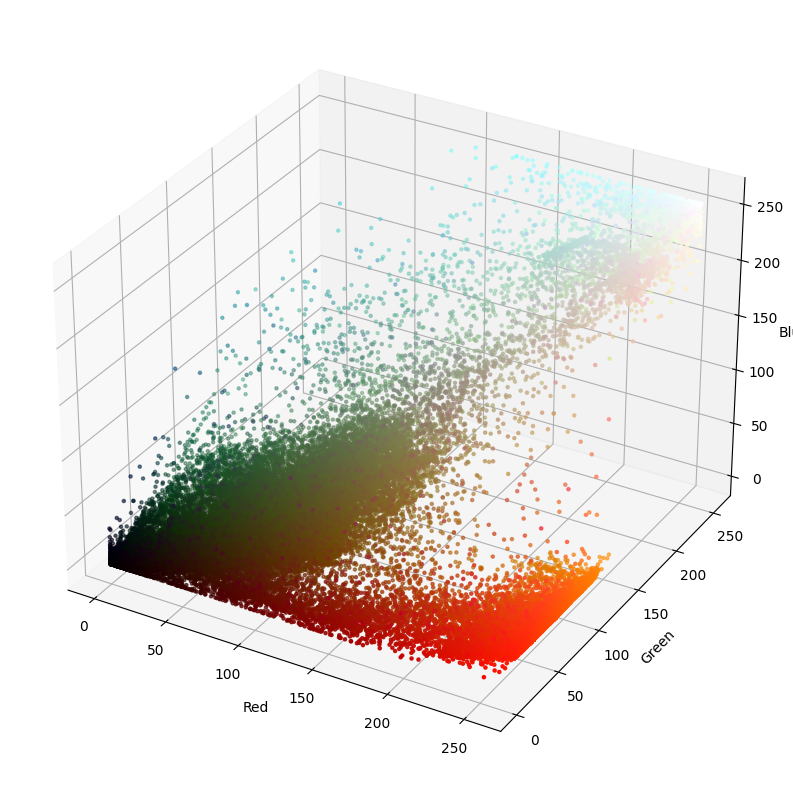

In [11]:
# Splitting components of image
r, g, b = cv2.split(nemo)

# Creating Figure for 3D plot
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection='3d')

# Normalising list of pixels
pixel_colors = nemo.reshape((np.shape(nemo)[0] * np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

# Plotting
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker='.')
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

Si bien, el sistema RGB es más facil de entender por nosotros y es ampliamente usado para la representación de colores, no es tan util para segmentar un color en particular. Esta tarea es más sencilla si convertimos la imágen al sistema HSV, para poder segmentar un color.

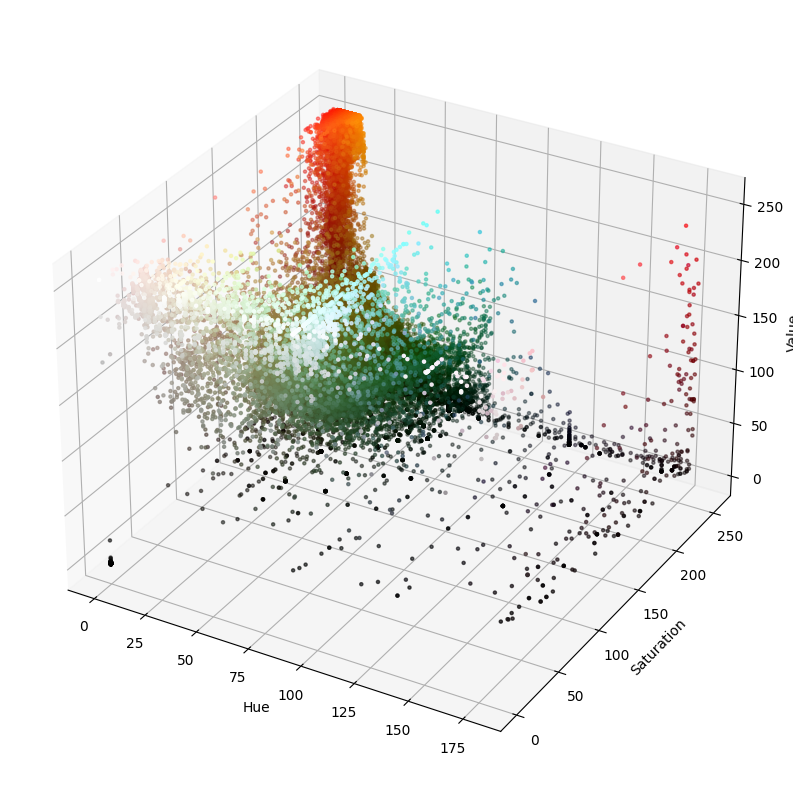

In [12]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV) # Convert the image from RGB to HSV

# Plotting distribution of pixels in 3D HSV colour space
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

Para el segundo gráfico se mantuvo la misma paleta de colores de los puntos, para poder ver que la separación del naranja en HSV es más apreciable.
A continuación se aplica una máscara para poder segmentar el color naranja de la imágen.

In [13]:
# Thresholds for segmenting Nemo
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)

In [14]:
# Segmenting Nemo according to thresholds, using a mask
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
segmented_nemo = cv2.bitwise_and(nemo, nemo, mask=mask)

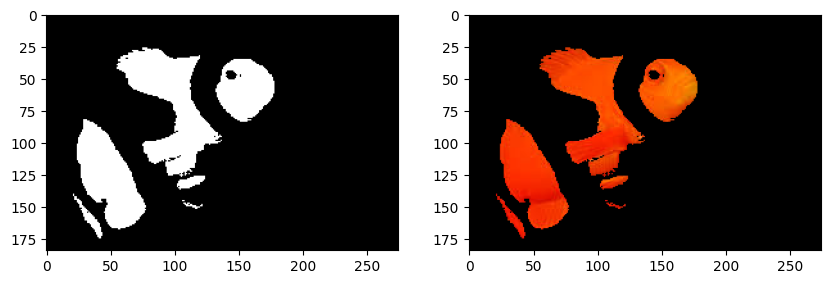

In [15]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_nemo)
plt.show()

Ahora se aplica una máscara para poder segmentar el color blanco de la imágen.

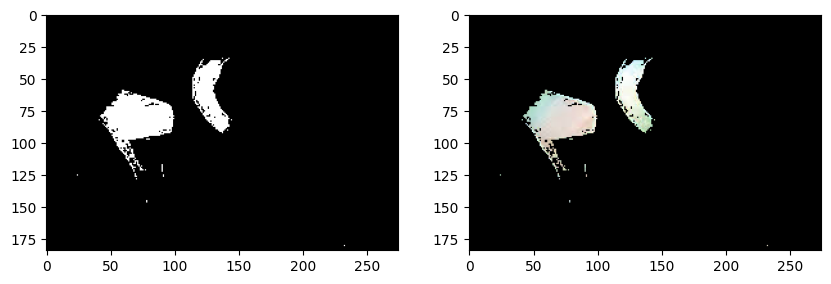

In [16]:
# Segmenting white stripes of Nemo
light_white = (0, 0, 200)
dark_white = (145, 60, 255)

mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)
result_white = cv2.bitwise_and(nemo, nemo, mask=mask_white)

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

Ahora utilizando ambas máscaras, se obtiene la segmentación completa de Nemo.

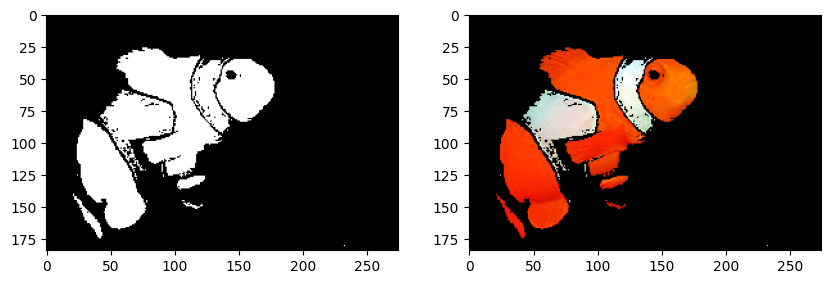

In [17]:
# Segmenting both white and orange parts of Nemo
final_mask = mask + mask_white
final_result = cv2.bitwise_and(nemo, nemo, mask=final_mask)

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

Aparecen unos puntos negros no deseados en la segmentación, para reducirlos se aplica un pasabajos gausseano que nos da una imágen más continua, sacando esas falsas detecciones.

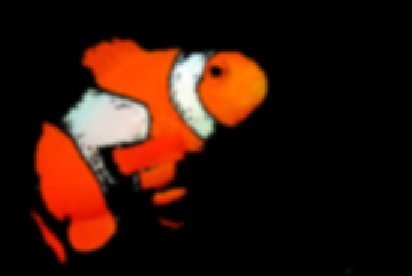

In [18]:
# Blurring to smoothen dark dots in the middle of Nemo
blur = cv2.GaussianBlur(final_result, (7, 7), 0)

h, w = blur.shape[:2]
displayImage_fromcv2(blur, int(w*1.5), int(h*1.5))

Ahora probamos todo este mismo procedimiento pero con otra imágen.

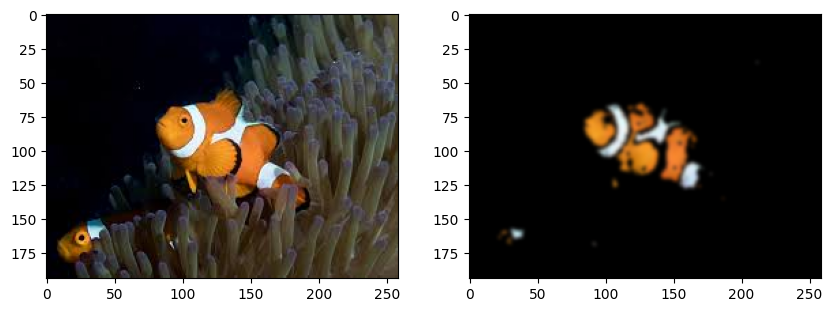

In [19]:
nemos_friend = cv2.imread("img/nemo5.jpg")
nemos_friend = cv2.cvtColor(nemos_friend, cv2.COLOR_BGR2RGB)
result = segment_fish(nemos_friend)
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(nemos_friend)
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Se puede ver como la segmentación para una imágen de un pez con cierta luz, tono y fondo no puede ser generalizado para cualquier imágen, pero si una aproximación aceptable. 

***
## 1.b - Aplicar los conceptos a la imagen bird.jpg

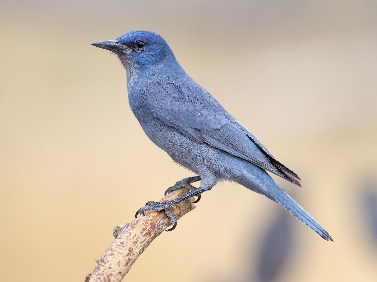

In [20]:
bird = cv2.imread("img/bird.jpg")
bird = cv2.cvtColor(bird, cv2.COLOR_BGR2RGB)
h, w = bird.shape[:2]
displayImage_fromcv2(bird, w//5, h//5)

Convertimos a HSV para poder segmentar el color

In [21]:
hsv_bird = cv2.cvtColor(bird, cv2.COLOR_RGB2HSV) # Convert the image from RGB to HSV

In [22]:
# Normalising list of pixels
pixel_colors_bird = bird.reshape((np.shape(bird)[0] * np.shape(bird)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors_bird)
pixel_colors = norm(pixel_colors_bird).tolist()

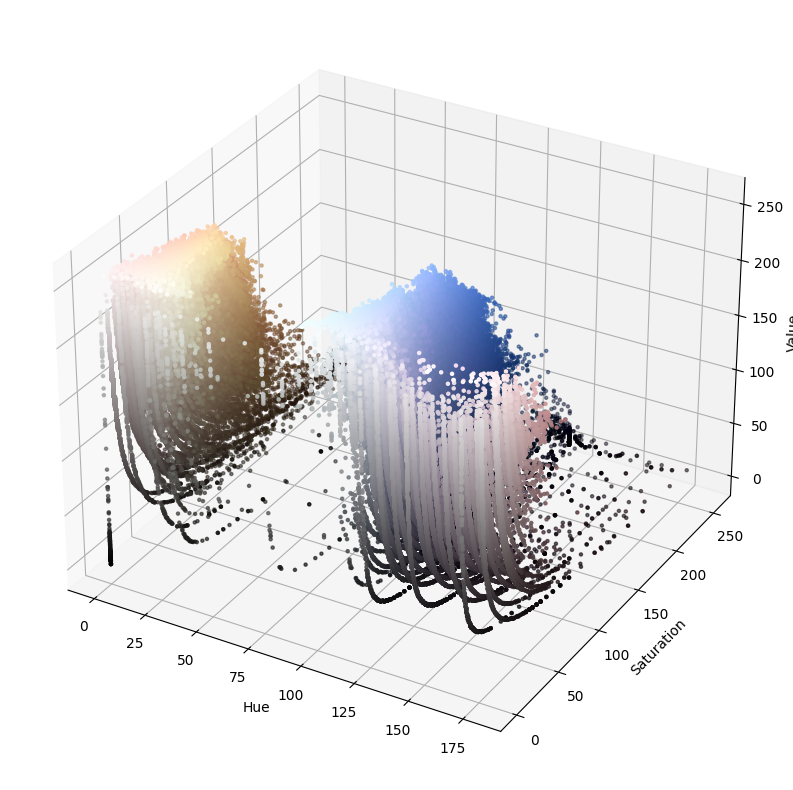

In [23]:
# Plotting distribution of pixels in 3D HSV colour space
h, s, v = cv2.split(hsv_bird)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [24]:
# Thresholds for segmenting Bird
light_blue = (100,0,0) 
dark_blue = (142, 255, 255)

In [25]:
# Segmenting bird according to thresholds, using a mask
mask = cv2.inRange(hsv_bird, light_blue, dark_blue)
segmented_bird = cv2.bitwise_and(bird, bird, mask=mask)

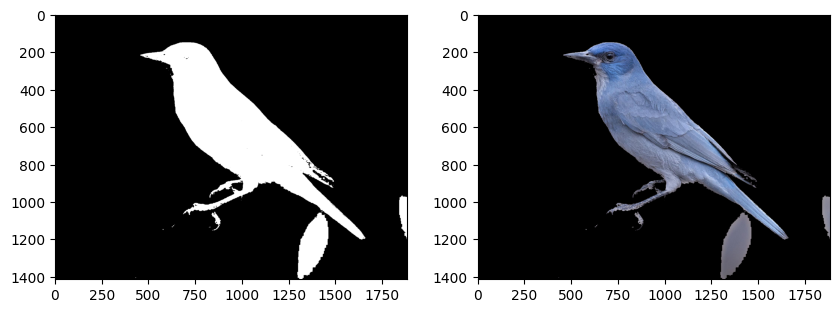

In [26]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_bird)
plt.show()

Observamos que si bien se elimino gran parte del contenido quedo un manchon en gris con tonalidades de azul, para esto se busca primero remover esa parte.

In [27]:
light_blue = (75, 0, 110)
dark_blue = (175, 50, 165)

In [28]:
# Segmenting bird according to thresholds, using a mask
mask_blue = 255 - cv2.inRange(hsv_bird, light_blue, dark_blue)
segmented_bird = cv2.bitwise_and(bird, bird, mask=mask_blue)

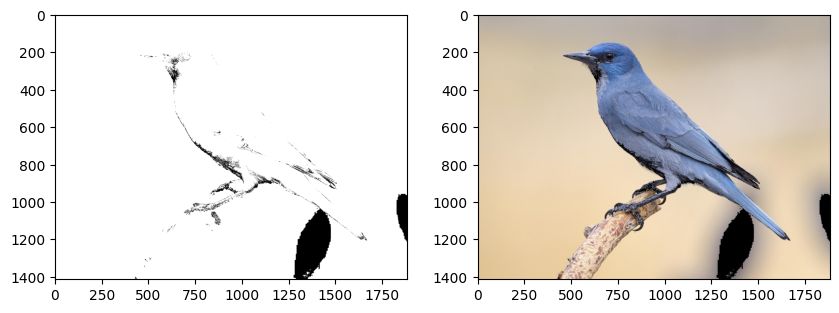

In [29]:
result_blue = cv2.bitwise_and(segmented_bird, segmented_bird, mask=mask_blue)
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.subplot(1, 2, 1)
plt.imshow(mask_blue, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_blue)
plt.show()

Una vez eliminada se vuelve a aplicar el filtro y se obtiene la imagen del ave aislada.

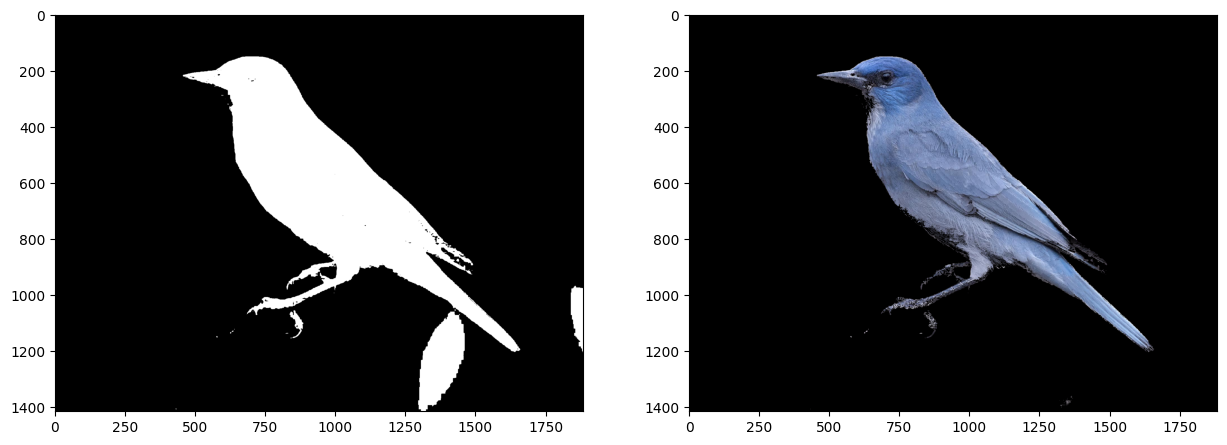

In [30]:
# Thresholds for segmenting Bird
light_blue = (100,0,0) 
dark_blue = (142, 255, 255)
# Segmenting bird according to thresholds, using a mask
mask = cv2.inRange(hsv_bird, light_blue, dark_blue)
segmented_bird = cv2.bitwise_and(result_blue, result_blue, mask=mask)
fig = plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_bird)
plt.show()

***
## 1.c - Dada la siguiente imagen se pide aislar la rosa dejando el resto en niveles de gris.

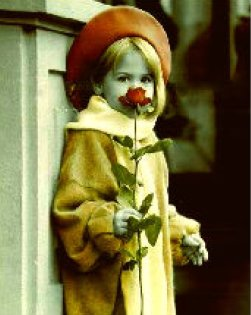

In [31]:
girl = cv2.imread("img/Girl_and_rose.jpg")
girl = cv2.cvtColor(girl, cv2.COLOR_BGR2RGB)
h, w = girl.shape[:2]
displayImage_fromcv2(girl, w, h)

In [32]:
hsv_girl = cv2.cvtColor(girl, cv2.COLOR_RGB2HSV) # Convert the image from RGB to HSV

In [33]:
# Normalising list of pixels
pixel_colors_girl = girl.reshape((np.shape(girl)[0] * np.shape(girl)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors_girl)
pixel_colors = norm(pixel_colors_girl).tolist()

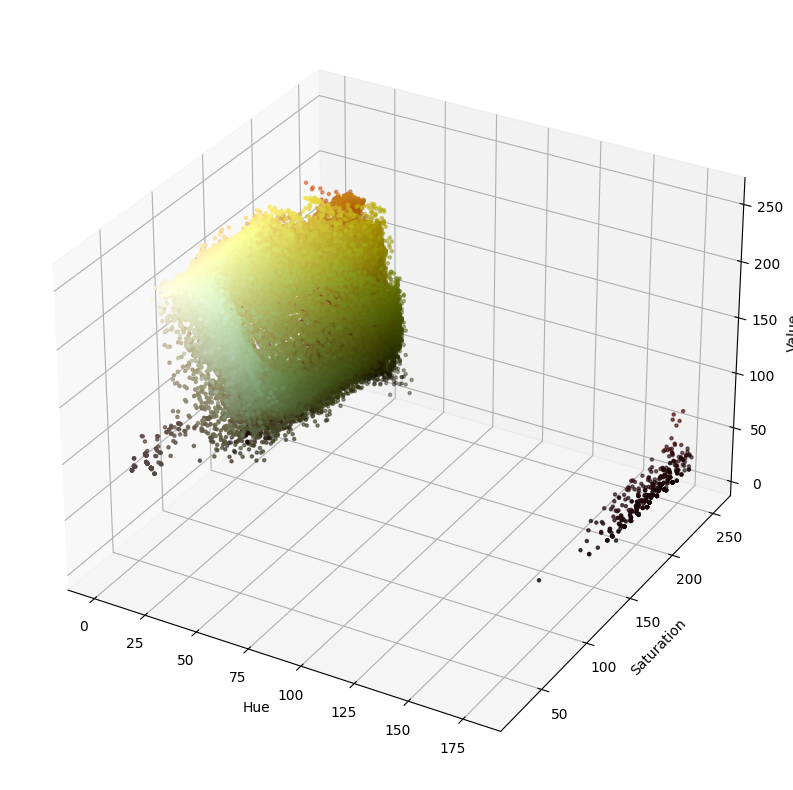

In [34]:
# Plotting distribution of pixels in 3D HSV colour space
h, s, v = cv2.split(hsv_girl)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

En primera instancia observamos que la imagen tiene una gran distribucion de color rojo. Aplicamos filtro correspondiente y aislamos las zonas en rojo.

In [35]:
light_red = (0, 210,70)
dark_red = (15, 255, 215)

In [36]:
# Segmenting bird according to thresholds, using a mask
mask = cv2.inRange(hsv_girl, light_red, dark_red)
segmented_girl = cv2.bitwise_and(girl, girl, mask=mask)

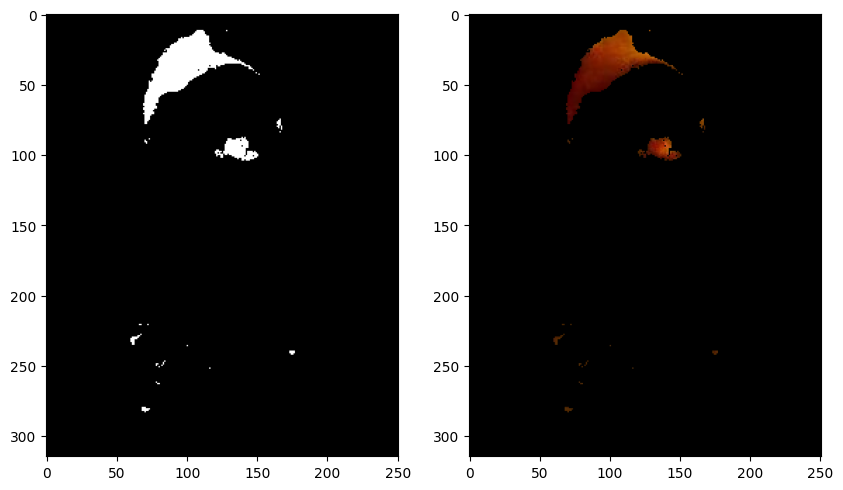

In [37]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_girl)
plt.show()

Como necesito solo la parte roja de la rosa mando a 0 todo el resto de la mascara.

In [38]:
rows,cols,_ = girl.shape
for i in range(rows):
    for j in range(cols):
        if i < 80 or i > 110 or j < 100 or j>160:
            mask[i,j]=0

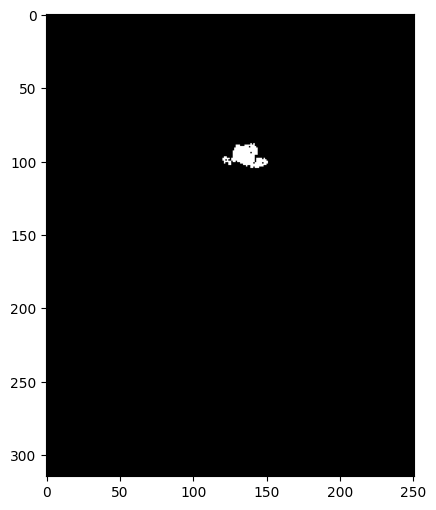

In [39]:
fig = plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='gray')

A continuacion removemos la rosa de la imagen original

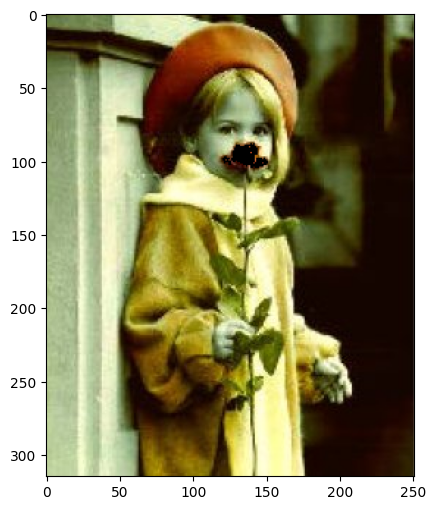

In [40]:
invMask = cv2.bitwise_not(mask)
girl_without_rose = cv2.bitwise_and(girl, girl, mask=invMask)
fig = plt.figure(figsize=(6,6))
plt.imshow(girl_without_rose, cmap='gray')

La convertimos en gris

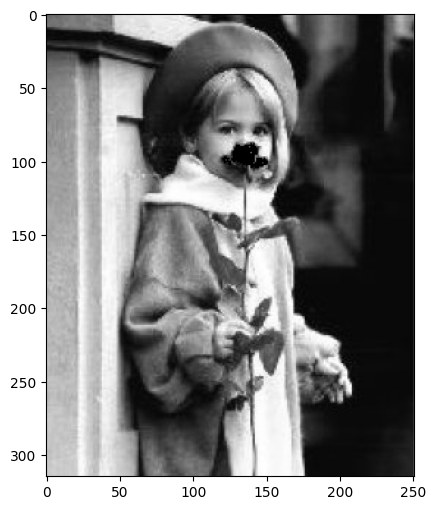

In [41]:
girl_without_rose_gray = cv2.cvtColor(girl_without_rose, cv2.COLOR_RGB2GRAY)
fig = plt.figure(figsize=(6,6))
plt.imshow(girl_without_rose_gray, cmap='gray')

Finalmente le agregamos la rosa en color y se obtiene el resultado final

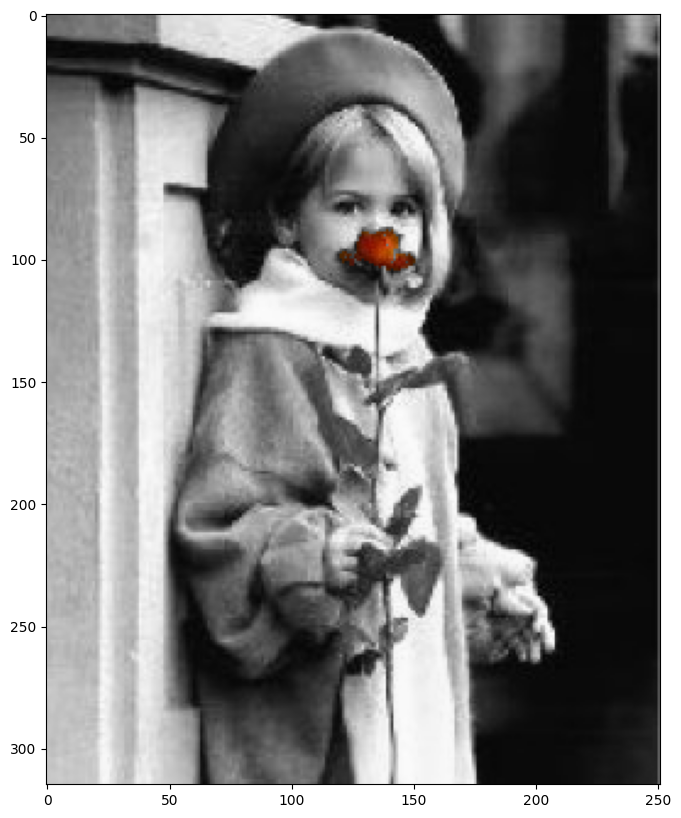

In [42]:
red_rose = cv2.bitwise_and(girl, girl, mask=mask)
girl_with_red_rose = cv2.cvtColor(girl_without_rose_gray, cv2.COLOR_GRAY2RGB) + red_rose
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.imshow(girl_with_red_rose)
plt.show()

***
# 1.d K-means clustering
Investigar como se usa el algoritmo k-means clustering para segmentar el color en una imagen. Implementar un ejemplo.

#### K-means clustering

Es un algoritmo dedicado a particionar $n$ elementos en $k$ segmentos o clusters. Cada í-esimo cluster está representado por un centroide $c_i$, cuya pocisión es la media de los datos que pertenecen a ese cluster, y los elementos del í-esimo cluster se definen como aquellos que se encuentran a menor distancia de $c_i$ que de cualquier otro $c_j$ ($j = 0...k-1, j\neq i$). Lo que se obtiene finalmente es que los clusters estan formados por elementos que comparten cierta similaridad.

El proceso del algoritmo es iterativo, y funciona de la siguiente manera:

1. Se tienen dos entradas, k y los $x_0...x_{n-1}$ datos a segmentar
2. Se poscicionan los centroides $c_0...c_{k-1}$ aleatoriamente
3. Se itera:
    
    1. se obtiene el centroide más cercano para cada dato, y se lo asigna al cluster asociado
    2. se repocisiona el centroide en la media de los datos pertenecientes a su cluster

Una vez que no se modifica el centroide entre una iteración y la siguiente, se finaliza el algoritmo. En comparación a otros algoritmos de segmentción, k-means clustering es el que requiere menor computación. Si se tiene una dimensión $d$ y requieren $i$ iteraciones para su convergencia, la complejidad del algoritmo es de $O(n\cdot k\cdot d\cdot i)$. Usualmente, suele suceder que el calculo de la media puede tener cierta variación o _jitter_ o que la convergencia de la media tome mucho tiempo, por lo que se suele definir también una condición a partir de la cual finalizar el algoritmo. 

El algoritmo permite un alto nivel de abstracción, siempre y cuando los datos sean numericos. Esto significa que los datos pueden ser posciciones en el espacio o color. Esto significa que el algoritmo puede utilizarse para segmentar imagenes en base a los colores que componen. De esta manera, el algoritmo puede utilizarse como una forma de _computer vision_, donde se define cada objeto por su color.

A continuación se realiza un ejemplo utilizando la libreria OpenCV.

Se abre la imagen y se configura su formato a RGB.

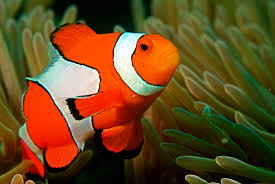

In [43]:
# abrir la imagen
image = cv2.imread("img/nemo0.jpg")
# convertir a RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# mostrar la imagen
h, w = image.shape[:2]
displayImage_fromcv2(image, w, h)

La imagen actualmente es de tres dimensiones, ancho, alto y color (los tres valores RGB). Para poder utilizar la función de OpenCV, la cual toma a los datos como arreglos de 2D, se aplana el ancho y alto en un solo vector y se mantiene el valor RGB. A su vez, la función de OpenCV toma valores de float32 para los colores. 

In [44]:
# convertir la imagen en un arreglo de pixeles
pixel_values = image.reshape((-1, 3))
# convert a float32
pixel_values = np.float32(pixel_values)

Se define el criterio de finalización para el algoritmo.

In [45]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

Se define la cantidad de clusters y se realiza el algoritmo.

La imagen del pez se identifican cuatro colores principales, naranja, blanco, negro, y el marrón claro de la anémona, por lo que se elige k=4.

In [46]:
k = 4
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

_labels_ indica el label del cluster indicado, mientras que _centers_ nos indica el valor de cada centroide.

Se convierten los valores de vualta de float32 a uint8.

In [47]:
centers = np.uint8(centers)

Se crea la imagen segmentada.

In [48]:
# convertir los pixeles a los colores de los centroides
segmented_image = centers[labels.flatten()]

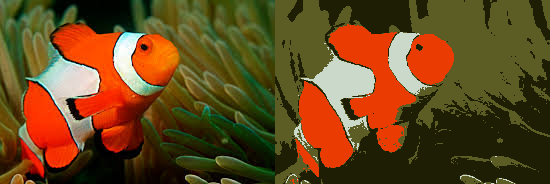

In [49]:
# volver a la forma original de la imagen
segmented_image = segmented_image.reshape(image.shape)
comparison = np.concatenate([image, segmented_image], axis=1)

# mostrar la imagen
h, w = image.shape[:2]
displayImage_fromcv2(comparison, 2*w, h)

***
# 2 - Procesamiento del Color
## a - Investigar qué es el filtro de bayer y dónde se usa

El filtro de Bayer es un patrón matricial de filtros para color rojo, verde y azul. Se utiliza en dispositivos de captura de imágenes como una cámara de fotos. 

En términos generales, el sensor de la cámara es capaz de detectar cuánta intensidad de iluminación llega a cada elemento de una grilla. Sin embargo, no puede por sí mismo determinar cuánta intensidad llega de cada color por separado. Sin algún proceso de filtrado, esto resultaría en una imagen en escala de grises. El filtro de Bayer utiliza una distribución de filtros monocromáticos tal que cada elemento de la grilla indique cuánta intensidad del color respectivo está siendo recibida.

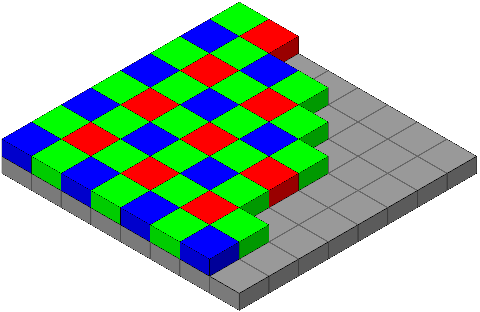

In [59]:
bayer = Image.open("img/Bayer_pattern_on_sensor.png")
w, h = bayer.size
displayImage(bayer, w//4, h//4)

Se utiliza el doble de filtros para color verde que para rojo y azul, debido a que nuestros ojos detectan luminancia en mayor proporción en ese canal. Bayer llamó a los fotosensores de verde "luminance-sensitive" y a los de rojo y azul "chrominance-sensitive", a pesar de que estríctamente todos detecten colores específicos.

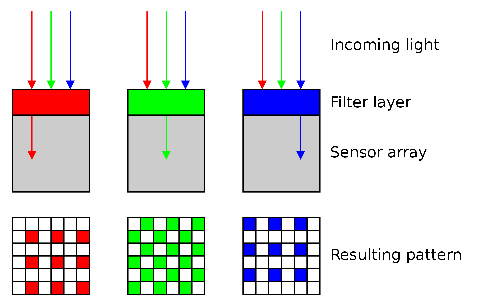

In [63]:
bayer = Image.open("img/Bayer_pattern_on_sensor_profile.png").convert('RGBA')
background = Image.new('RGBA', bayer.size, (255,255,255))
bayer = Image.alpha_composite(background, bayer)
w, h = bayer.size
displayImage(bayer, w//4, h//4)

_Fuente de las dos imágenes anteriores: By Cburnett - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=1496872_

El problema es que la información que aporta el resultado de este proceso nos da la información de un solo canal para cada pixel correspondiente a su posición en la grilla. Esto se resuelve utilizando técnicas de _demosaicing_.

## b - ¿Qué es Demosaicing?

Las técnicas utilizadas para obtener información de todos los canales para cada pixel se denominan _demosaicing_. Esto es porque el resultado del filtro de Bayer es un mosáico con un color por pixel. El objetivo es conseguir valores para los dos colores que no se encuentran presentes naturalmente en una posición determinada.

Existen diversas formas de lograrlo, entre las cuales las más simples consisten en interpolar los valores faltantes utilizando a los vecinos cercanos. El problema de utilizar únicamente la interpolación es que los bordes con alto contraste sufrirán de difuminación. Por este motivo, técnicas más avanzadas consideran factores como bordes para implementar interpolaciones más inteligentes y lograr mejores resultados.

Otra consideración que se puede tener en cuenta es que el ojo humano detecta con mucho mayor la luminancia que la crominancia, por lo que concentrarse en la intensidad con otros métodos además de la mayor proporción de celdas verdes puede resultar en una imagen más nítida, a pesar de que un zoom podría revelar borrones entre colores.

## c - Implementar y explicar el ejemplo del siguiente link
https://cs.brown.edu/courses/csci1290/labs/lab_raw/index.html

In [64]:
from scipy.signal import convolve2d

In [100]:
def wbscalematrix(m, n, wb_scales, align):
    # Makes a white-balance scaling matrix for an image of size m-by-n
    # from the individual RGB white balance scalar multipliers [wb_scales] = [R_scale G_scale B_scale].
    #
    # [align] is string indicating the 2x2 Bayer arrangement: 
    # 'rggb':  
    #    R G
    #    G B
    # 'gbrg':
    #    G B
    #    R G
    # 'grbg','bggr' follow as before.
    #
    # 

    # First, for convenience only, we're going to fill the scale matrix
    # with all green pixels. Then, we're going to replace the red and blue 
    # pixels later on with the correct scalars.
    #
    scalematrix = wb_scales[1] * np.ones((m,n)) # Initialize to all green values

    # Fill in the scales for the red and blue pixels across the matrix
    if (align == 'rggb'):
        scalematrix[0::2, 0::2] = wb_scales[0] # r
        scalematrix[1::2, 1::2] = wb_scales[2] # b
    elif (align == 'bggr'):
        scalematrix[1::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 0::2] = wb_scales[2] # b
    elif (align == 'grbg'):
        scalematrix[0::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    elif (align == 'gbrg'):
        scalematrix[1::2, 0::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    return scalematrix


def apply_cmatrix(img, cmatrix):
    # Applies color transformation CMATRIX to RGB input IM. 
    # Finds the appropriate weighting of the old color planes to form the new color planes, 
    # equivalent to but much more efficient than applying a matrix transformation to each pixel.
    if (img.shape[2] != 3):
        raise ValueError('Apply cmatrix to RGB image only.')

    r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
    g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
    b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
    corrected = np.stack((r,g,b), axis=2)
    return corrected


def debayering(input):
    # Bilinear Interpolation of the missing pixels
    #
    # Assumes a Bayer CFA in the 'rggb' layout (Habría que hacerlo genérico?)
    #   R G R G
    #   G B G B
    #   R G R G
    #   G B G B
    #
    # Input: Single-channel rggb Bayered image
    # Returns: A debayered 3-channels RGB image
    #
    img = input.astype(np.double)

    m = img.shape[0]
    n = img.shape[1]

    # First, we're going to create indicator masks that tell us
    # where each of the color pixels are in the bayered input image
    # 1 indicates presence of that color, 0 otherwise
    red_mask = np.tile([[1,0],[0,0]], (int(m/2), int(n/2)))     # El /2 en las dims es porque damos un patron de 2x2 (queda m x n)
    green_mask = np.tile([[0,1],[1,0]], (int(m/2), int(n/2)))
    blue_mask = np.tile([[0,0],[0,1]], (int(m/2), int(n/2)))

    r = np.multiply(img, red_mask)
    g = np.multiply(img, green_mask)
    b = np.multiply(img, blue_mask)

    # Confirm for yourself: 
    # - What are the patterns of values in the r,g,b images?
    # Sketch them out to help yourself. (Listo!)

    # Next, we're going to fill in the missing values in r,g,b
    # For this, we're going to use filtering - convolution - to implement bilinear interpolation.
    # - We know that convolution allows us to perform a weighted sum
    # - We know _where_ our pixels lie within a grid, and where the missing pixels are
    # - We know filters come in odd sizes

    # Interpolating green:
    filter_g = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_g = convolve2d(g, filter_g, 'same')
    g = g + missing_g

    # To conceptualize how this works, let's continue to draw it out on paper.
    # - Sketch the first 5 rows and columns of the g image
    # - Sketch the 3x3 filter and add the numeric weights (they sum to 1)
    # - Sketch the output image

    # Move the filter through the valid region of the image.
    # - What is the output at pixel 1,1 ?  [0-index, remember]
    # - What is the output at pixel 2,1 ?
    # - What is the output at pixel 3,1 ?
    # - What is the output at pixel 1,2 ?
    # - What is the output at pixel 2,2 ?
    # - What is the output at pixel 3,2 ?

    # See how it works? 
    # The filter only produces output if the surrounding pixels match its pattern.
    # When they do, it produces their mean value.

    # Note that we're going to have some incorrect values at the image boundaries, 
    # but let's ignore that for this exercise. (Lo que expliqué en el punto anterior!!)

    # Now, let's try it for blue. This one is a two-step process.
    # - Step 1: We fill in the 'central' blue pixel in the location of the red pixel
    # - Step 2: We fill in the blue pixels at the locations of the green pixels, 
    #           similar to how the green interpolation worked, but offset by a row/column
    #
    # Sketch out the matrices to help you follow.
    # Remember, we'll still have some incorrect value at the image boundaries.

    # Interpolating blue:
    # Step 1:
    filter1 = 0.25 * np.array([[1,0,1],[0,0,0],[1,0,1]])
    missing_b1 = convolve2d(b, filter1, 'same')
    # Step 2:
    filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_b2 = convolve2d(b + missing_b1, filter2, 'same')
    b = b + (missing_b1 + missing_b2)

    # OK! Only red left.

    # Interpolation for the red at the missing points
    # Complete the following two lines. Follow a similar strategy to the blue channel.
    # Noto que filter1 y filter2 son los mismos para rojo!!
    missing_r1 = convolve2d(r, filter1, 'same')
    missing_r2 = convolve2d(r + missing_r1, filter2, 'same')
    r = r + missing_r1 + missing_r2

    output = np.stack((r,g,b), axis=2)
    return output

Datos RAW


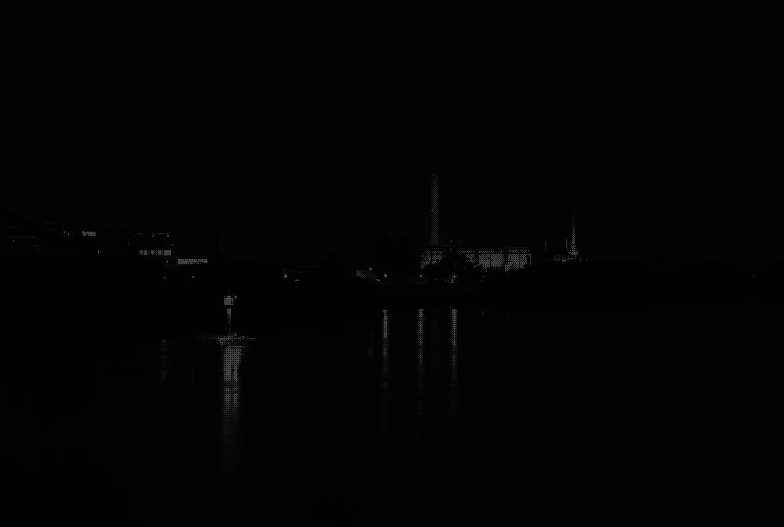

Datos normalizados por el valor de saturación


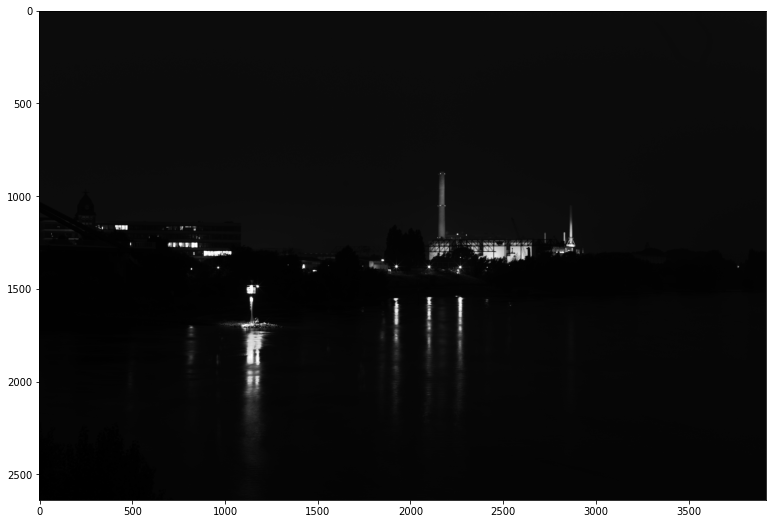

White balancing


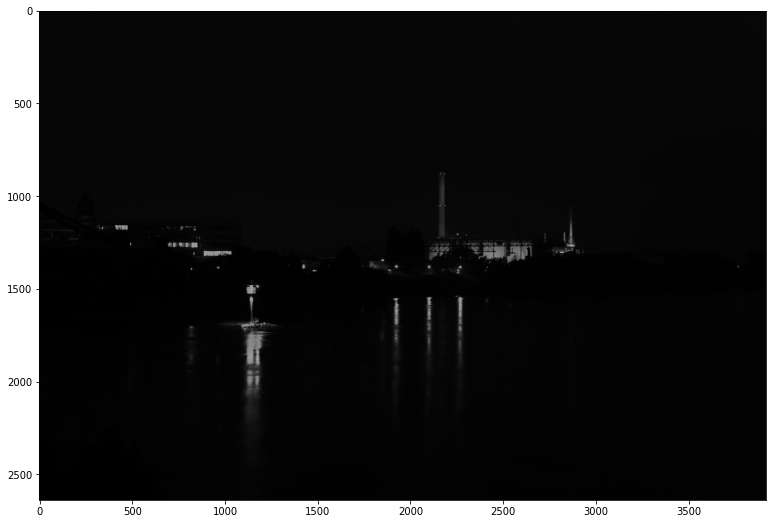

Demosaicing


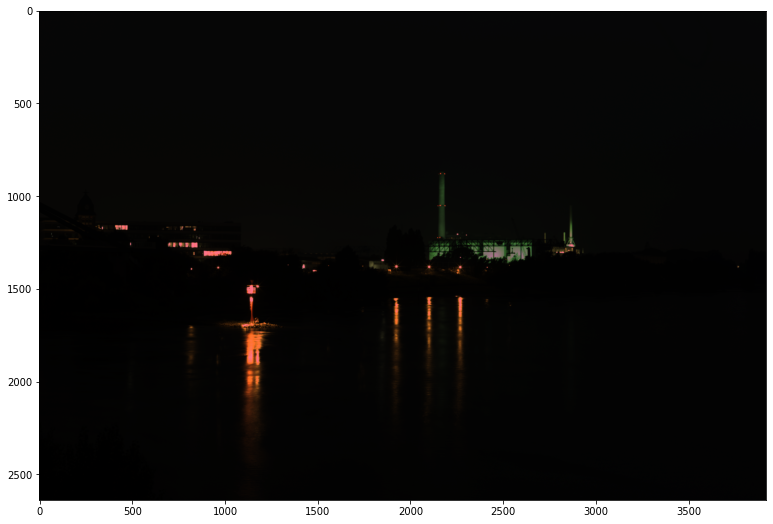

Conversión del espacio de colores


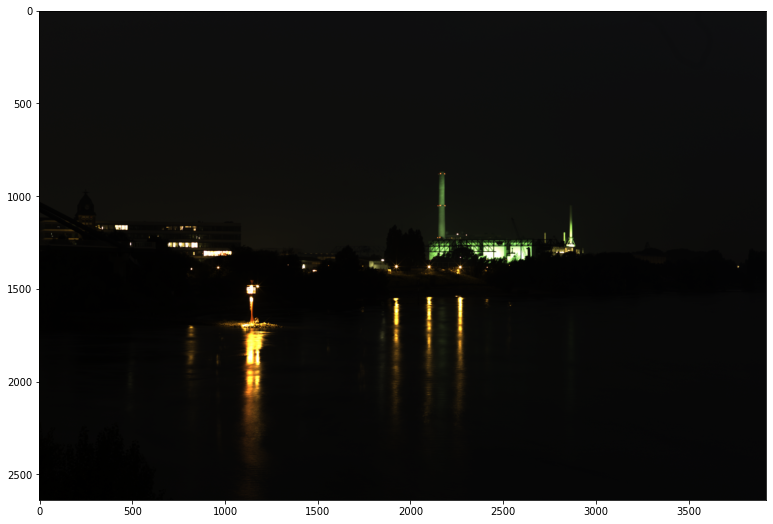

Escalamiento de brillo


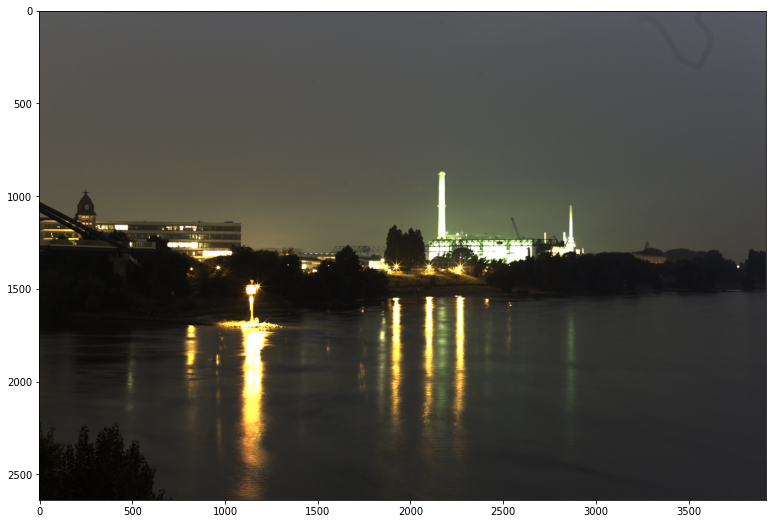

Corrección de gamma con formula exponencial


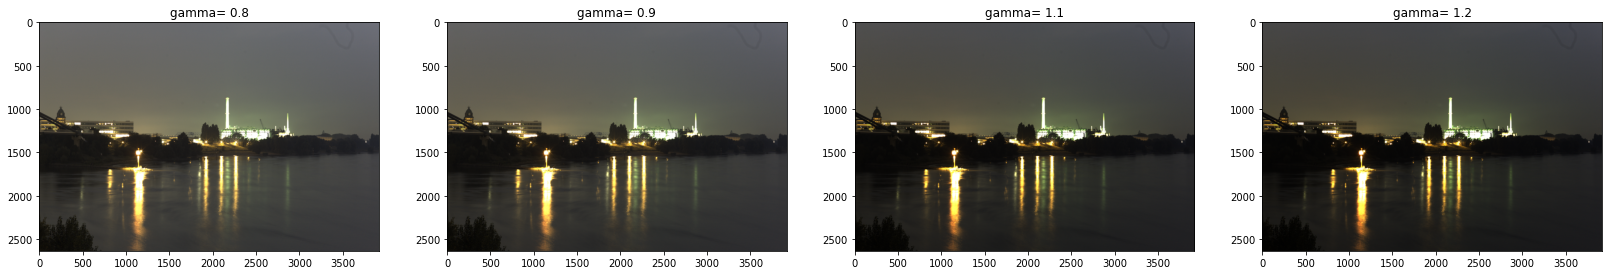

In [153]:
# Step 0: Convert RAW file to TIFF
# Fill in the following scalars with a "reconnaissance run".
# 'black': the black point in the RAW image
black = 0
# 'saturation': This is the value at which the sensor can no longer produce any higher values.
# This is _not_ anything to do with 'saturation' in terms of color spaces, e.g., HSV color space.
saturation = 16383  
# 'wb_multipliers': white balance multipliers for each of the R, G, B channels
wb_multipliers = [2.217041, 1.000000, 1.192484]

# Use the output file from command "dcraw -4 -D -T <raw_file_name>"
raw_data = Image.open('img/sample.tiff')
w, h = raw_data.size

print("Datos RAW")
displayImage(raw_data, w//5, h//5)

raw = np.array(raw_data).astype(np.double)

# Step 1: Normalization
# Map raw to range [0,1].
linear_bayer = raw/saturation

print("Datos normalizados por el valor de saturación")
fig = plt.figure(figsize=(18,9))
plt.imshow(linear_bayer, cmap='gray')
plt.show()

# Step 2: White balancing
# Complete the function wbmask().
mask = wbscalematrix(linear_bayer.shape[0], linear_bayer.shape[1], wb_multipliers, 'rggb')
balanced_bayer = np.multiply(linear_bayer, mask)

print("White balancing")
fig = plt.figure(figsize=(18,9))
plt.imshow(balanced_bayer, cmap='gray')
plt.show()

# Step 3: Debayering (also called demosaicing)
# Complete the function debayering().
lin_rgb = debayering(balanced_bayer)

print("Demosaicing")
fig = plt.figure(figsize=(18,9))
plt.imshow(lin_rgb/np.max(lin_rgb))
plt.show()

# Step 4: Color space conversion --- we do this one for you.
# Convert to sRGB. xyz2cam is found in dcraw's source file adobe_coeff.
rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
           [0.2126729, 0.7151522, 0.0721750],
           [0.0193339, 0.1191920, 0.9503041]])
xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
           [-0.4221, 1.3303, 0.0929],
           [-0.0881, 0.2416, 0.7226]])
rgb2cam = xyz2cam * rgb2xyz # Assuming previously defined matrices
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
rgb2cam = np.divide(rgb2cam, denom) # Normalize rows to 1
cam2rgb = np.linalg.inv(rgb2cam)
lin_srgb = apply_cmatrix(lin_rgb, cam2rgb)
lin_srgb[lin_srgb > 1.0] = 1.0 # Always keep image clipped b/w 0-1
lin_srgb[lin_srgb < 0.0] = 0.0

print("Conversión del espacio de colores")
fig = plt.figure(figsize=(18,9))
plt.imshow(lin_srgb)
plt.show()

# Step 5: Brightness and gamma correction
# Feel free to modify the consts.
desired_bright = 0.25
bright_srgb = lin_srgb.copy()

while(np.mean(bright_srgb) < desired_bright):
    bright_factor = desired_bright/np.mean(bright_srgb)
    bright_srgb = bright_srgb*bright_factor
    bright_srgb[bright_srgb > 1.0] = 1.0 # Always keep image clipped b/w 0-1

print("Escalamiento de brillo")
fig = plt.figure(figsize=(18,9))
plt.imshow(bright_srgb)
plt.show()

gammas = [0.8, 0.9, 1.1, 1.2]
images = {}

for gamma in gammas:
    images["gamma= "+str(gamma)] = np.power(bright_srgb, gamma)

print("Corrección de gamma con formula exponencial")
compare(images)